In [ ]:
%pip install ultralytics -q
%pip install pyyaml -q

import os
import yaml
from ultralytics import YOLO


# Kaggle input
input_path = '/kaggle/input/x-ray-contraband-detection-dataset' 

print("Root Directory Contents:", os.listdir(input_path))


In [ ]:
import os
import yaml


dataset_root = '/kaggle/input/x-ray-contraband-detection-dataset'


train_path = ""
val_path = ""
test_path = ""

for root, dirs, files in os.walk(dataset_root):
    if 'images' in dirs:
        images_path = os.path.join(root, 'images')
        if 'train' in os.listdir(images_path):
            train_path = os.path.join(images_path, 'train')
        if 'val' in os.listdir(images_path):
            val_path = os.path.join(images_path, 'val')
        if 'test' in os.listdir(images_path):
            test_path = os.path.join(images_path, 'test')
        break 


if not train_path:
    for root, dirs, files in os.walk(dataset_root):
        if 'train' in dirs:
             potential_train = os.path.join(root, 'train')
             if 'images' in os.listdir(potential_train):
                 train_path = os.path.join(potential_train, 'images')
             else:
                 train_path = potential_train 
             
        if 'val' in dirs or 'valid' in dirs:
            v_dir = 'val' if 'val' in dirs else 'valid'
            potential_val = os.path.join(root, v_dir)
            if 'images' in os.listdir(potential_val):
                 val_path = os.path.join(potential_val, 'images')
            else:
                 val_path = potential_val

print(f"Detected Train Path: {train_path}")
print(f"Detected Val Path:   {val_path}")
print(f"Detected Test Path:  {test_path}")


new_yaml = {
    'path': '', 
    'train': train_path,
    'val': val_path,
    'test': test_path, 
    'nc': 12,
    'names': ['Baton', 'Plier', 'Hammer', 'Powerbank', 'Scissors', 'Wrench', 'Gun', 'Bullet', 'Sprayer', 'HandCuffs', 'Knife', 'Lighter']
}


yaml_save_path = '/kaggle/working/custom_data.yaml'

with open(yaml_save_path, 'w') as f:
    yaml.dump(new_yaml, f, default_flow_style=None)

print(f"\nYAML file successfully created at: {yaml_save_path}")
print("YAML Content:")
print(new_yaml)

Görsel: /kaggle/input/x-ray-contraband-detection-dataset/data/images/train/PID_xray_08812.jpg
Etiket: /kaggle/input/x-ray-contraband-detection-dataset/data/labels/train/PID_xray_08812.txt


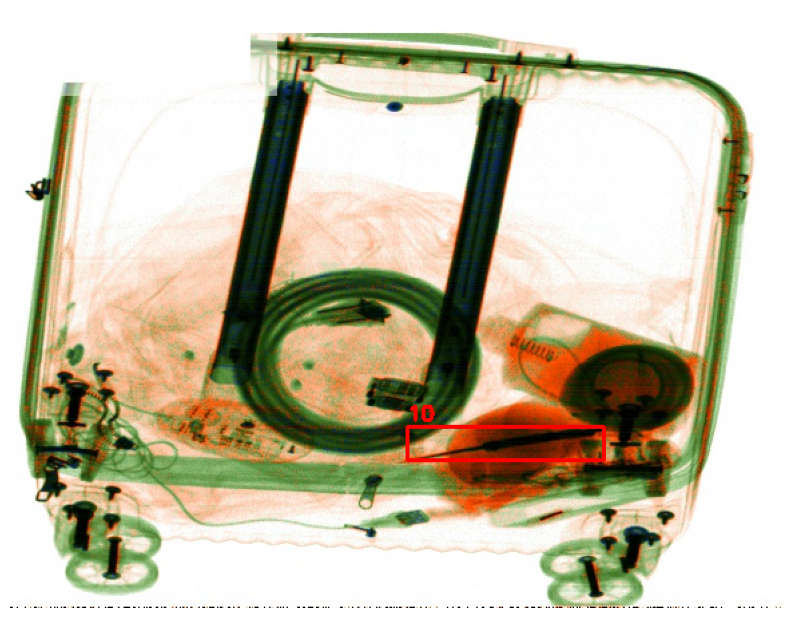

In [ ]:
import cv2
import matplotlib.pyplot as plt
import random


image_files = os.listdir(train_path)
random_image = random.choice(image_files)
img_path = os.path.join(train_path, random_image)

# .../images/train/X.jpg -> .../labels/train/X.txt
label_path = img_path.replace('images', 'labels').replace('.jpg', '.txt').replace('.png', '.txt')

print(f"Görsel: {img_path}")
print(f"Etiket: {label_path}")

image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
h, w, _ = image.shape

if os.path.exists(label_path):
    with open(label_path, 'r') as f:
        lines = f.readlines()
        
    for line in lines:
        parts = line.strip().split()
        class_id = int(parts[0])
        x_center, y_center, width, height = map(float, parts[1:])
        
        # YOLO
        x1 = int((x_center - width / 2) * w)
        y1 = int((y_center - height / 2) * h)
        x2 = int((x_center + width / 2) * w)
        y2 = int((y_center + height / 2) * h)
        
        # Kutu çiz
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
        cv2.putText(image, str(class_id), (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
import os
from ultralytics import YOLO

dataset_yaml = '/kaggle/working/custom_data.yaml'

hybrid_config = """
nc: 12   

backbone:
  - [-1, 1, Conv, [64, 3, 2]]
  - [-1, 1, Conv, [128, 3, 2]]
  - [-1, 3, C2f, [128]]
  - [-1, 1, Conv, [256, 3, 2]]
  - [-1, 6, C2f, [256]]
  - [-1, 1, Conv, [512, 3, 2]]
  - [-1, 6, C2f, [512]]
  - [-1, 1, Conv, [1024, 3, 2]]
  - [-1, 3, C2f, [1024]]
  - [-1, 1, SPPF, [1024, 5]]

head:
  - [-1, 1, nn.Upsample, [None, 2, 'nearest']]
  - [[-1, 6], 1, Concat, [1]]
  - [-1, 3, C2fAttn, [512]]   #Transformer-style Attention Fusion

  - [-1, 1, nn.Upsample, [None, 2, 'nearest']]
  - [[-1, 4], 1, Concat, [1]]
  - [-1, 3, C2fAttn, [256]]   #Transformer-style Attention Fusion

  - [-1, 1, Conv, [256, 3, 2]]
  - [[-1, 12], 1, Concat, [1]]
  - [-1, 3, C2f, [512]]

  - [-1, 1, Conv, [512, 3, 2]]
  - [[-1, 9], 1, Concat, [1]]
  - [-1, 3, C2f, [1024]]

  - [[15, 18, 21], 1, Detect, [nc]]
"""

# Save the custom architecture
with open('ag_dexdet_arch.yaml', 'w') as f:
    f.write(hybrid_config)

# 3. Load Model with AG-DEXDet Architecture
# We use YOLOv11 weights as a starting point
model = YOLO('ag_dexdet_arch.yaml')
model.load('yolo11s.pt', strict=False)

# 4. Train with Fusion (Matches Paper Hyperparameters)
results = model.train(
    data=dataset_yaml,
    epochs=15,          
    imgsz=640,          #
    batch=16,           #
    optimizer='Adam',   #
    lr0=0.001,          #
    cos_lr=True,        # Cosine Annealing
    amp=False,          # Stability fix for Transformer layers
    name='ag_dexdet_fusion',
    device=0
)

Transferred 499/499 items from pretrained weights
Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 14913MiB)
engine/trainer: agnostic_nms=False, amp=False, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/kaggle/working/custom_data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=15, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.yaml, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=ag_dexdet_fusion, nbs=64, nms=False, opset=None, optimize=Fals

In [8]:
from ultralytics import YOLO
import pandas as pd

# 1. Load the best fine-tuned model
# 'best.pt' is automatically saved by YOLOv8 at the end of training
# model = YOLO('/kaggle/working/runs/detect/xray_project/weights/best.pt')

# 2. Run validation
# This will use the 'val' path defined in your custom_data.yaml
metrics = model.val()

# 3. Print Global Metrics
print("\n" + "="*30)
print("OVERALL PERFORMANCE")
print("="*30)
map50 = metrics.results_dict['metrics/mAP50(B)']
map50_95 = metrics.results_dict['metrics/mAP50-95(B)']
precision = metrics.results_dict['metrics/precision(B)']
recall = metrics.results_dict['metrics/recall(B)']

# F1 Score calculation
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"mAP@50:      {map50:.4f}")
print(f"mAP@50-95:   {map50_95:.4f}")
print(f"Precision:   {precision:.4f}")
print(f"Recall:      {recall:.4f}")
print(f"F1-Score:    {f1_score:.4f}")

# 4. Print Per-Class Metrics (mAP50)
print("\n" + "="*30)
print("PER-CLASS mAP@50")
print("="*30)
names = model.names
for i, class_map in enumerate(metrics.box.maps):
    print(f"{names[i]:<15}: {class_map:.4f}")

# Note: Visual results (Confusion Matrix, PR Curve, F1 Curve) 
# are saved in: /kaggle/working/runs/detect/val/

Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 14913MiB)
YOLO11s summary (fused): 101 layers, 9,417,444 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 125.0±118.1 MB/s, size: 77.8 KB)
val: Scanning /kaggle/input/x-ray-contraband-detection-dataset/data/labels/val... 1373 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1373/1373 827.6it/s 1.7s
WARNING ⚠️ val: Cache directory /kaggle/input/x-ray-contraband-detection-dataset/data/labels is not writable, cache not saved.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 86/86 5.2it/s 16.5s
                   all       1373       1794      0.903      0.804      0.887      0.726
                 Baton        143        148      0.931      0.926      0.961      0.824
                 Plier        142        168      0.923      0.639       0.84      0.606
                Hammer        135        142      0.947      0.91

In [ ]:
from ultralytics import YOLO
from sklearn.metrics import classification_report
import numpy as np

# 1. Load your trained model
# model = YOLO('/kaggle/working/runs/detect/xray_project/weights/best.pt')

# 2. Run validation to get predictions
# We use stream=True or just collect results from the validation set
results = model.val()

# 3. YOLOv11 stores confusion matrix data which we can use to extract metrics
# However, for a standard report, we often compare 'targets' vs 'predictions'
# Here is how to access the per-class stats directly from the metrics object:
names = model.names
stats = results.results_dict

print("YOLOv11 Per-Class Summary:")
for i, name in names.items():
    p = results.box.p[i]  # Precision per class
    r = results.box.r[i]  # Recall per class
    f1 = 2 * (p * r) / (p + r) if (p + r) > 0 else 0
    print(f"Class: {name:<12} | Precision: {p:.3f} | Recall: {r:.3f} | F1: {f1:.3f}")

Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 14913MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 159.1±95.2 MB/s, size: 85.5 KB)
val: Scanning /kaggle/input/x-ray-contraband-detection-dataset/data/labels/val... 1373 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1373/1373 1.2Kit/s 1.2s
WARNING ⚠️ val: Cache directory /kaggle/input/x-ray-contraband-detection-dataset/data/labels is not writable, cache not saved.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 86/86 5.1it/s 16.8s
                   all       1373       1794      0.903      0.804      0.887      0.726
                 Baton        143        148      0.931      0.926      0.961      0.824
                 Plier        142        168      0.923      0.639       0.84      0.606
                Hammer        135        142      0.947      0.915      0.975      0.896
             Powerbank        147        154      0.887      0

In [10]:
import os
import yaml
from ultralytics import YOLO
from sklearn.metrics import classification_report
import numpy as np

# 1. Update the YAML file to include the test path
dataset_yaml = '/kaggle/working/custom_data.yaml'
with open(dataset_yaml, 'r') as f:
    data_config = yaml.safe_load(f)

# Set the test path explicitly
data_config['test'] = '/kaggle/input/x-ray-contraband-detection-dataset/data/images/test'

with open(dataset_yaml, 'w') as f:
    yaml.dump(data_config, f)

# 2. Load your best fine-tuned Fusion model
# Assuming the model from the previous step was named 'ag_dexdet_fusion'
# model_path = '/kaggle/working/runs/detect/ag_dexdet_fusion/weights/best.pt'
# model = YOLO(model_path)

# 3. Run Validation on the TEST split
# split='test' tells the model to use the test images we just added to the YAML
metrics = model.val(data=dataset_yaml, split='test')

# 4. Extract and Print mAP Metrics
print("\n" + "="*40)
print("TEST SET PERFORMANCE (mAP)")
print("="*40)
print(f"mAP@50:      {metrics.results_dict['metrics/mAP50(B)']:.4f}")
print(f"mAP@50-95:   {metrics.results_dict['metrics/mAP50-95(B)']:.4f}")

# 5. Generate Classification Report
# We use the Confusion Matrix generated during testing to build a standard report
names = model.names
nc = len(names)
cm = metrics.confusion_matrix.matrix

y_true = []
y_pred = []

# Reconstruct ground truth and predictions from the confusion matrix
for i in range(nc): # True classes
    for j in range(nc + 1): # Predicted classes (including background at index nc)
        count = int(cm[i, j])
        y_true.extend([i] * count)
        y_pred.extend([j] * count)

# Map indices to names (treating the last index as 'Background/False Positive')
target_names = [names[i] for i in range(nc)]
labels = list(range(nc))

print("\n" + "="*40)
print("DETECTION CLASSIFICATION REPORT")
print("="*40)
print(classification_report(y_true, y_pred, labels=labels, target_names=target_names, digits=4))

# 6. Per-Class mAP@50
print("\n" + "="*40)
print("PER-CLASS mAP@50")
print("="*40)
for i, class_map in enumerate(metrics.box.maps):
    print(f"{names[i]:<15}: {class_map:.4f}")

Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 14913MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 16.7±7.1 MB/s, size: 88.0 KB)
val: Scanning /kaggle/input/x-ray-contraband-detection-dataset/data/labels/test... 1358 images, 15 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1373/1373 223.8it/s 6.1s
WARNING ⚠️ val: Cache directory /kaggle/input/x-ray-contraband-detection-dataset/data/labels is not writable, cache not saved.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 86/86 5.2it/s 16.6s
                   all       1373       1807      0.885      0.823      0.886      0.712
                 Baton        130        140      0.838      0.925      0.856      0.669
                 Plier        116        133      0.842      0.684      0.837      0.609
                Hammer        142        144       0.93      0.965      0.981      0.921
             Powerbank        150        156      0.856      

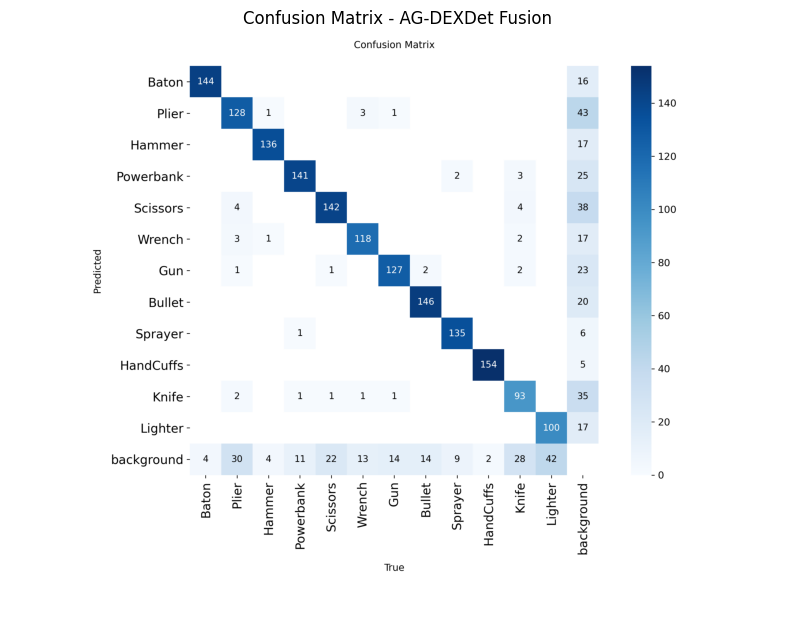

In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Path to the results of your test evaluation
results_dir = '/kaggle/working/runs/detect/val' # Check your specific run folder name

# Plot Confusion Matrix
plt.figure(figsize=(10, 10))
img = mpimg.imread(f'{results_dir}/confusion_matrix.png')
plt.imshow(img)
plt.axis('off')
plt.title("Confusion Matrix - AG-DEXDet Fusion")
plt.show()